<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
Return Prediction Model 
</h1>

###  Overview  
***  
In this part of the capstone project, we develop a complete classification pipeline to predict whether a transaction is likely to be returned.  
The notebook covers data preprocessing, feature engineering, handling class imbalance with SMOTE, training baseline and advanced models, evaluating performance using multiple metrics, and interpreting model behavior to identify high-risk return transactions.


###  Importing Required Libraries
***
Here we import all necessary libraries for data manipulation, feature engineering, time-series processing, preprocessing, and model building.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


### Chunking and Stratified Sampling Approach
***
Since the dataset contains **more than 6 million rows**, loading and processing the full data at once can lead to high memory usage and significantly slow down training. When we attempted to **train Logistic Regression on the entire dataset, the process took nearly two hours and still failed** due to memory limitations. To avoid such bottlenecks, we use data chunking—reading the dataset in smaller batches instead of loading everything into memory at once. Chunking enables efficient preprocessing, reduces RAM consumption, and keeps the workflow stable. Before applying chunking, we also **ensure stratified sampling** so the class distribution (0 vs 1) remains consistent across chunks, preventing imbalance distortion and maintaining representativeness


In [2]:
chunksize=500_000
chunks=[]
target_col="Is_Return"
for chunk in pd.read_csv(r"D:\WsCube_Tech_Capstone_Project\return_prediction_data_with_header.csv", chunksize=chunksize):
    sample_chunk=chunk.groupby(target_col).sample(frac=0.2,random_state=42).reset_index(drop=True)
    chunks.append(sample_chunk)
df=pd.concat(chunks, ignore_index=True)
df.head()

,Customer_ID,Product_ID,Store_ID,Unit_Price,Quantity,Amount,Currency,Months,Weekdays,Payment_Method,...,Total_Cust_Return,Cust_Return_Rate,Total_Cust_Spent,Avg_Cust_Spend,Total_Prod_Txn,Total_Prod_Return,Prod_Return_Rate,Total_Store_Txn,Total_Store_Return,Store_Return_Rate
0,48578,12824,1,103.5,1,103.50,USD,10,1,0,...,0,0.0,632.30,79.04,709,37,0.05219,477743,25282,0.05292
1,47546,13298,1,48.5,1,29.10,USD,1,5,0,...,0,0.0,125.10,62.55,841,42,0.04994,477743,25282,0.05292
2,58851,14521,1,43.0,1,43.00,USD,9,5,0,...,1,0.2,186.50,37.30,887,44,0.04961,477743,25282,0.05292
3,38636,6699,1,75.5,1,75.50,USD,9,0,1,...,0,0.0,291.30,48.55,678,29,0.04277,477743,25282,0.05292
4,53654,3324,1,55.5,1,36.08,USD,3,0,0,...,0,0.0,86.83,28.94,406,26,0.06404,477743,25282,0.05292


### Data Inspection: Info, Nulls, Duplicates, and Description

***

Before cleaning or modeling, we perform an initial inspection of the dataset. This step uses key methods: **`.info()`** to check data types and non-null counts, **`.isnull().sum()`** to identify the total number of missing values per column, **`.duplicated().sum()`** to count any duplicate rows, and **`.describe()`** to view the statistical summary of numerical features. This ensures data quality and readiness for preprocessing.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283365 entries, 0 to 1283364
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Customer_ID         1283365 non-null  int64  
 1   Product_ID          1283365 non-null  int64  
 2   Store_ID            1283365 non-null  int64  
 3   Unit_Price          1283365 non-null  float64
 4   Quantity            1283365 non-null  int64  
 5   Amount              1283365 non-null  float64
 6   Currency            1283365 non-null  object 
 7   Months              1283365 non-null  int64  
 8   Weekdays            1283365 non-null  int64  
 9   Payment_Method      1283365 non-null  int64  
 10  Is_Discounted       1283365 non-null  int64  
 11  Is_Return           1283365 non-null  int64  
 12  Total_Cust_Txn      1283365 non-null  int64  
 13  Total_Cust_Return   1283365 non-null  int64  
 14  Cust_Return_Rate    1283365 non-null  float64
 15  Total_Cust_Spen

In [4]:
df.isnull().sum()

Customer_ID           0
Product_ID            0
Store_ID              0
Unit_Price            0
Quantity              0
Amount                0
Currency              0
Months                0
Weekdays              0
Payment_Method        0
Is_Discounted         0
Is_Return             0
Total_Cust_Txn        0
Total_Cust_Return     0
Cust_Return_Rate      0
Total_Cust_Spent      0
Avg_Cust_Spend        0
Total_Prod_Txn        0
Total_Prod_Return     0
Prod_Return_Rate      0
Total_Store_Txn       0
Total_Store_Return    0
Store_Return_Rate     0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(251)

In [6]:
df.describe()

,Customer_ID,Product_ID,Store_ID,Unit_Price,Quantity,Amount,Months,Weekdays,Payment_Method,Is_Discounted,...,Total_Cust_Return,Cust_Return_Rate,Total_Cust_Spent,Avg_Cust_Spend,Total_Prod_Txn,Total_Prod_Return,Prod_Return_Rate,Total_Store_Txn,Total_Store_Return,Store_Return_Rate
count,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,...,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06,1.283365e+06
mean,7.326732e+05,9.261280e+03,1.345860e+01,1.324197e+02,1.100434e+00,1.276916e+02,7.254207e+00,3.512040e+00,2.000483e-01,2.791412e-01,...,6.654147e-01,5.278065e-02,1.221842e+03,1.277440e+02,5.698552e+02,3.017811e+01,5.294250e-02,2.491851e+05,1.318802e+04,5.292624e-02
std,4.874632e+05,3.854254e+03,1.013504e+01,1.850040e+02,3.969871e-01,2.038317e+02,3.856105e+00,2.090645e+00,4.000364e-01,4.485772e-01,...,1.590450e+00,1.062410e-01,2.068211e+03,1.603944e+02,2.427656e+02,1.401746e+01,1.201191e-02,1.277044e+05,6.762318e+03,7.631451e-04
min,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.400000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.750000e+00,1.750000e+00,6.000000e+00,0.000000e+00,0.000000e+00,6.747400e+04,3.487000e+03,5.126000e-02
25%,2.944330e+05,6.384000e+03,5.000000e+00,3.250000e+01,1.000000e+00,2.730000e+01,3.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.133000e+02,3.712000e+01,3.980000e+02,2.000000e+01,4.594000e-02,1.317560e+05,6.891000e+03,5.234000e-02
50%,6.766290e+05,9.154000e+03,1.000000e+01,5.100000e+01,1.000000e+00,4.650000e+01,8.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,4.381500e+02,4.875000e+01,5.850000e+02,3.100000e+01,5.263000e-02,2.038870e+05,1.069200e+04,5.292000e-02
75%,1.138936e+06,1.267700e+04,2.200000e+01,1.165000e+02,1.000000e+00,1.207500e+02,1.100000e+01,5.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,6.250000e-02,1.018570e+03,9.935000e+01,7.870000e+02,4.100000e+01,5.963000e-02,3.703710e+05,1.938700e+04,5.349000e-02
max,1.643297e+06,1.794000e+04,3.500000e+01,1.153500e+03,3.000000e+00,3.460500e+03,1.200000e+01,6.000000e+00,1.000000e+00,1.000000e+00,...,2.800000e+01,7.600000e-01,2.636368e+04,3.336000e+03,9.970000e+02,7.700000e+01,3.000000e-01,4.777430e+05,2.528200e+04,5.511000e-02


### Target Check
***

In [7]:
print(df['Is_Return'].value_counts())
print("-"*120)
print(df['Is_Return'].value_counts(normalize=True))

Is_Return
0    1215441
1      67924
Name: count, dtype: int64
------------------------------------------------------------------------------------------------------------------------
Is_Return
0    0.947074
1    0.052926
Name: proportion, dtype: float64


### Data Preparation for Modeling
***
Before model training, we cleaned the dataset by **removing duplicates** and **dropping unnecessary columns.** Since only the ‘currency’ column was categorical, we applied **one-hot encoding** to it. Month and weekday features were transformed using **cyclical sine–cosine encoding**, numerical columns were scaled using **StandardScaler**, and already normalized or binary features were passed through ‘passthrough’. These preprocessing steps ensured clean, consistent, and model-ready data.




In [8]:
df=df.drop_duplicates()

#Cyclical/Circular Encoding using Sine–Cosine Transformation

df["Sin_Month"] = np.sin(2 * np.pi * df["Months"] / 12)
df["Cos_Month"] = np.cos(2 * np.pi * df["Months"] / 12)

df["Sin_Weekday"] = np.sin(2 * np.pi * df["Weekdays"] / 7)
df["Cos_Weekday"] = np.cos(2 * np.pi * df["Weekdays"] / 7)

drop_col=['Customer_ID', 'Product_ID', 'Store_ID','Weekdays','Months']

num_col=['Unit_Price', 'Quantity', 'Amount',
    'Total_Cust_Txn', 'Total_Cust_Return',
    'Total_Cust_Spent', 'Avg_Cust_Spend',
    'Total_Prod_Txn', 'Total_Prod_Return',
    'Total_Store_Txn', 'Total_Store_Return']

cat_col=['Currency']

pass_col=['Cust_Return_Rate', 'Prod_Return_Rate', 'Store_Return_Rate','Payment_Method', 'Is_Discounted','Sin_Month', 'Cos_Month', 'Sin_Weekday', 'Cos_Weekday']

df=df.drop(columns=drop_col)

### Feature–Target Separation
***

To prepare the data for modeling, we separated the **independent variables (features)** and the **dependent variable (target)**. All relevant **input columns were assigned to X**, while the **return indicator column was assigned to y**. This separation is essential because machine learning algorithms require features and target to be passed separately during training (fit) and evaluation (predict).





In [9]:
x=df.drop(columns="Is_Return")
y=df["Is_Return"]

### Preprocessing Setup Using ColumnTransformer
***

**A ColumnTransformer** was configured to preprocess each feature group appropriately: **numerical columns** were **scaled** using **StandardScaler**, the **categorical ‘currency’ column** was **one-hot encoded**, and **already standardized** or **binary columns were passed through unchanged**. This ensures consistent and correct preprocessing before feeding the data into the model pipeline.




In [10]:
preprocess_steps= ColumnTransformer([("num_trf",StandardScaler(),num_col),
                                     ("cat_trf",OneHotEncoder(sparse_output=True,handle_unknown="ignore"),cat_col),
                                     ("pass_trf","passthrough",pass_col)],
                                    remainder="drop")

### Pipeline with SMOTE Using ImbPipeline
***

**SMOTE** is included in the pipeline **to handle the severe class imbalance by generating synthetic samples for the minority class**, helping the model learn balanced patterns. **We use ImbPipeline (instead of the normal Pipeline)** because **it correctly applies SMOTE only on the training data** during cross-validation, preventing data leakage and ensuring fair, unbiased model training.




In [11]:
lr_pipeline = Pipeline([ ("preprocess_steps",preprocess_steps), ('smote', SMOTE(random_state=42)), ("lr_model",LogisticRegression(max_iter=2000, class_weight="balanced")) ])

### Train–Test Split for Model Evaluation
***

The dataset was **split into training and testing sets** using an **80–20 ratio** while preserving the class distribution through stratified sampling. Stratification ensures that both sets maintain the same proportion of positive and negative labels, preventing bias and giving a more reliable evaluation of model performance. This split allows the model to learn on the training data and be tested on unseen data for fair validation.




In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)

### Model Training with Imbalanced-Learn Pipeline
***

**The imblearn Pipeline is fitted on the training data**, allowing preprocessing, SMOTE oversampling, and Logistic Regression training to run in sequence. Using the **imbalanced-learn Pipeline ensures that SMOTE is applied only to the training portion during fitting**, preventing data leakage and helping the model learn balanced patterns from both classes.



In [13]:
lr_pipeline.fit(x_train,y_train)

,steps,"[('preprocess_steps', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_trf', ...), ('cat_trf', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Finding the Best Classification Threshold Using ROC Curve
***
**This code calculates predicted probabilities, generates the ROC curve, and identifies the optimal threshold** where the difference between True Positive Rate (**TPR**) and False Positive Rate (**FPR**) is **maximum** (Youden’s J-statistic). **Instead of using the default 0.5 cutoff, it selects a threshold that gives the best balance between sensitivity(TPR) and specificity(FPR)**. Finally, it converts probabilities into class labels using this improved threshold.

In [14]:
lr_prob=lr_pipeline.predict_proba(x_test)[:,1]

fpr, tpr, thr = roc_curve(y_test, lr_prob)
j = tpr - fpr
best_thresh = thr[np.argmax(j)]
best_thresh

lr_pred=(lr_prob>best_thresh).astype(int)

### Best Threshold & Confusion Matrix
***

**Displays the optimal probability cutoff (Youden’s J) along with the confusion matrix to evaluate classification performance at that threshold.**




In [15]:
print(f"Best Threshold: {best_thresh}")
print("-"*120)
cm=confusion_matrix(y_test, lr_pred)
print(f"Confusion Matrix:\n{cm}")
print("-"*120)

Best Threshold: 0.327974049528304
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[202028  41047]
 [   148  13400]]
------------------------------------------------------------------------------------------------------------------------


### Confusion Matrix Visualization
***

**Plots the confusion matrix graphically to clearly show true positives, true negatives, false positives, and false negatives.**




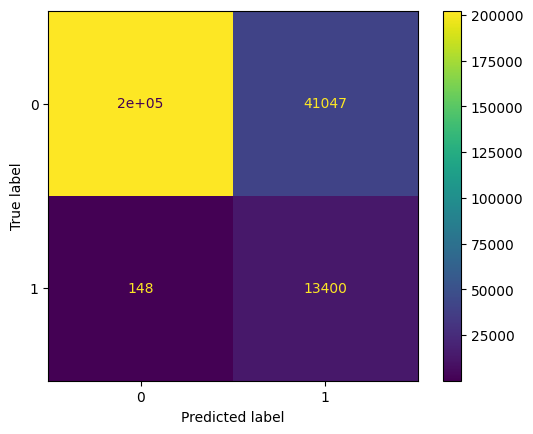

In [16]:
disp=ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Model Evaluation – Classification & ROC-AUC
***

The classification report shows **precision**, **recall**, and **F1-score** for each class, while the **ROC-AUC score** measures the model’s overall ability to distinguish between returned and non-returned transactions.




In [17]:
cr=classification_report(y_test, lr_pred)
print(f"Classification Report:\n{cr}")
roc_auc = roc_auc_score(y_test, lr_prob)
print(f"ROC-AUC: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91    243075
           1       0.25      0.99      0.39     13548

    accuracy                           0.84    256623
   macro avg       0.62      0.91      0.65    256623
weighted avg       0.96      0.84      0.88    256623

ROC-AUC: 0.9519946769689275


<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
    Logistic Regression - Model Interpretation (Metric-by-Metric)
</h1>

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
1. Precision
</h3>

**Precision = 0.30**
   - Only **30%** of predicted class 1 are actually class 1.
   - Precision drops because the model predicts class-1 very often.

**Why?**
- **SMOTE** makes minority class more frequent in training
- **class_weight** increases the penalty for misclassifying minority-class samples, making the model treat class-1 errors more seriously.

**Meaning:**

    - This produces many false positives, reducing precision.
    - This is expected when using BOTH techniques(SMOTE+class_weight).

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
2. Recall
</h3>

**Recall = 0.90**
   - Your model correctly captures **90%** of all actual class 1 cases.

**Why?**
- **SMOTE:** Creates many synthetic class-1 samples → model becomes better at learning class-1.
- **class_weight:** Gives class-1 more weight → model avoids misclassifying class-1 as 0.

**Meaning:**

    - Excellent recall
    - Very few false negatives
    - Good for situations where missing a positive is costly (e.g., fraud, return prediction).
    - The combination pushes the model toward detecting class-1 more aggressively, which is why your recall is very high

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
3. F1 Score
</h3>

**F1 Score = 0.45**

- Moderate score because F1 balances precision and recall.

**Why?**
- High recall pushes F1 up
- Low precision pulls F1 down

**Meaning:**

    - F1 is a compromise between low precision (0.30) and high recall (0.89).
    - It shows the model heavily favors detecting positives, even if it misclassifies zeros

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
4. Accuracy
</h3>

**Accuracy = 0.88**

- Model is **88%** accurate.

**Why?**
- **accuracy is high only because the dataset is very imbalanced.It does not reflect how well the model handles the minority class.**


**Meaning:**

    - This is misleading because the data is heavily imbalanced (class 0 dominates).
    - You should rely more on F1, recall, and precision.

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
5. ROC–AUC
</h3>

**ROC–AUC = 0.952**
- This is the strongest indicator of your model’s performance

**Meaning:**

    - 95.2% probability that the model ranks a random positive higher than a random negative
    - The model has excellent class separability
    - Even though your chosen threshold causes low precision, the overall model curve is strong

<h2 style="text-align: center;">
  <span style="background-color:#C7B8E7; color: black; padding: 5px; border-radius: 5px;">
     Combined Interpretation
  </span>
</h2>

Your **Logistic Regression** model shows **very strong ability to detect class-1 cases** due to the **combined effect of SMOTE and class_weight**, which makes it highly sensitive toward the minority class. This results in an excellent **recall of 0.90** and a strong **ROC–AUC of 0.952**, indicating that the model has learned to separate the classes very effectively. However, because the model aggressively predicts class-1 to avoid missing positives, **precision drops to 0.30**, and the **F1 score balances out at 0.45**. The accuracy of 0.88 is high but misleading due to the dataset’s imbalance. **Overall, the model is tuned to maximize detection of class-1 even at the cost of producing more false positives, making it suitable for scenarios where catching positives is more important than maintaining high precision.**

### Setting Up the Random Forest Pipeline
****

This section builds an end-to-end Random Forest pipeline that includes preprocessing, SMOTE-based oversampling, and a tuned classifier. The model is optimized for large, highly imbalanced data by combining synthetic minority sampling and balanced class weighting to improve class-1 detection while keeping the model efficient and stable.

In [18]:
rf = RandomForestClassifier(
    n_estimators=200,                           # good for 1M+ rows
    max_depth=8,                               # prevents overfitting
    criterion='gini',                           # simple and fast
    class_weight='balanced_subsample',          # handle 95:5 imbalance
    n_jobs=-1,                                  # use all CPU cores
    random_state=42
)
rf_pipeline=Pipeline(steps=[("preprocess_steps",preprocess_steps),("smote", SMOTE(k_neighbors=3, random_state=42)),("rf_model", rf)])

### Model Training with SMOTE-Enhanced Random Forest
***

The Random Forest pipeline is trained on the preprocessed dataset, where **SMOTE is applied inside the pipeline to balance the minority class before fitting the model**. This step ensures that the classifier learns from both classes effectively, reducing bias toward the majority class and improving recall on imbalanced datasets.




In [19]:
rf_pipeline.fit(x_train, y_train)

,steps,"[('preprocess_steps', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_trf', ...), ('cat_trf', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Threshold Optimization & Final Predictions for Random Forest
***

This block computes the predicted probabilities from the Random Forest model and **uses the ROC curve to identify the optimal decision threshold**—where the difference between TPR and FPR is maximized. After selecting this best threshold, the model generates final class predictions and evaluates performance using the confusion matrix, giving a more balanced and data-driven classification outcome.




In [20]:
rf_prob=rf_pipeline.predict_proba(x_test)[:,1]

rf_fpr, rf_tpr, rf_thr = roc_curve(y_test, rf_prob)
i = rf_tpr - rf_fpr
rf_best_thresh = rf_thr[np.argmax(i)]
best_thresh

rf_pred=(rf_prob>rf_best_thresh).astype(int)

print(f"Best Random Forest Threshold: {rf_best_thresh}")
print("-"*120)
rf_cm=confusion_matrix(y_test, rf_pred)
print(f"Confusion Matrix:\n{rf_cm}")
print("-"*120)

Best Random Forest Threshold: 0.4739685299526084
------------------------------------------------------------------------------------------------------------------------
Confusion Matrix:
[[204780  38295]
 [   111  13437]]
------------------------------------------------------------------------------------------------------------------------


### Visualizing the Random Forest Confusion Matrix
***

**A confusion matrix plot is generated** to clearly visualize how well the optimized Random Forest model distinguishes between class-0 and class-1 predictions.

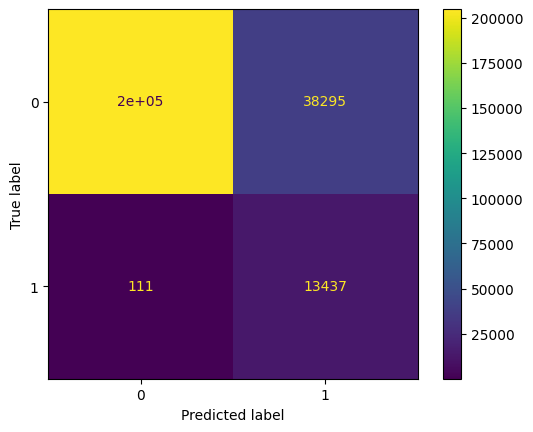

In [21]:
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot()

### Model Evaluation – Classification & ROC-AUC
***

The classification report shows **precision**, **recall**, and **F1-score** for each class, while the **ROC-AUC score** measures the model’s overall ability to distinguish between returned and non-returned transactions.



In [22]:
rf_cr=classification_report(y_test, rf_pred)
print(f"Classification Report:\n{rf_cr}")
rf_roc_auc = roc_auc_score(y_test, rf_prob)
print(f"ROC-AUC: {rf_roc_auc}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    243075
           1       0.26      0.99      0.41     13548

    accuracy                           0.85    256623
   macro avg       0.63      0.92      0.66    256623
weighted avg       0.96      0.85      0.89    256623

ROC-AUC: 0.9522814459798297


<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
    Random Forest - Model Interpretation (Metric-by-Metric)
</h1>


<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
1. Precision
</h3>

**Precision = 0.26**
- Only 26% of predicted class-1 samples are actually correct.
- Precision is lower than Logistic Regression, meaning the Random Forest produces even more false positives.
- This happens because SMOTE + class_weight make the model aggressively predict class-1.



<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
2. Recall
</h3>

**Recall = ~1.00**
- The model captures almost every actual class-1 case.
- Out of 13,548 actual positives, it misses only 111, which is extremely strong but not perfect.
- This behavior is expected because Random Forest + SMOTE + class_weight strongly push the model toward detecting positives.

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
3. F1 Score
</h3>

**F1 Score = 0.41**

- Slightly lower than Logistic Regression (0.45).
- Because F1 balances precision and recall, the very low precision pulls it down despite extremely high recall.

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
4. Accuracy
</h3>

**Accuracy = 0.85**

- Slightly lower than logistic regression, still misleading due to imbalance.

<h3 style="background-color: black; color: white; padding: 2px 6px; border-radius: 4px; width: fit-content; font-size: 18px;">
5. ROC–AUC
</h3>

**ROC–AUC = 0.952**
- Almost the same as Logistic Regression (0.95199) — only a very small improvement.
- Indicates that Random Forest has slightly stronger class separation, but both models rank positives and negatives almost equally well.
- Shows that the model is structurally strong even if threshold-based metrics (precision, F1) are affected by imbalance.

<h2 style="text-align: center;">
  <span style="background-color:#C7B8E7; color: black; padding: 5px; border-radius: 5px;">
     Combined Interpretation
  </span>
</h2>

Your **Random Forest model** remains highly sensitive to class-1 detection due to SMOTE and balanced class weighting, achieving an excellent **recall (~0.99)** and a strong **ROC–AUC of 0.9522**. However, this sensitivity increases false positives, **reducing precision to 0.25** and keeping the **F1 score moderate at 0.41**. Accuracy (0.85) is still not a reliable indicator because of heavy imbalance. **Overall, this model is effective when capturing almost all positive cases is the top priority, and some false positives are acceptable.**

<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
Overall Model Evaluation Summary
</h1>

<h2 style="text-align: center;">
  <span style="background-color:#C7B8E7; color: black; padding: 5px; border-radius: 5px;">
    Final Conclusion
  </span>
</h2>

**Both models strongly prioritize detecting class-1 cases due to SMOTE and class_weight. Logistic Regression provides a more balanced performance with higher precision and better F1-score, while Random Forest is more aggressive and achieves much higher recall and the best ROC–AUC, but with more false positives.**

<h2 style="text-align: center;">
  <span style="background-color:#C7B8E7; color: black; padding: 5px; border-radius: 5px;">
    Final Recommendation
  </span>
</h2>

- Choose Random Forest if the goal is to catch as many class-1 cases as possible and missing a positive is costly.
- Choose Logistic Regression if you want a more balanced model that reduces false positives and offers more stable interpretable predictions.

    - **If recall is the priority → Random Forest wins.**
    - **If precision balance matters → Logistic Regression wins.**